## Clasificación de Discurso de Odio usando BERT y Modelos Tradicionales

En este notebook, se implementan diferentes técnicas de clasificación para clasificar diferentes frases en discurso de odio, o discurso sin odio. 

Para ello, se extraen los embeddings haciendo uso de un modelo BERT pre-entrenado, y posteriormente se clasifican a través de un algoritmo de ML clásico. 

Posteriormente, se proponen otras alternativas para mejorar los resultados de la clasificación.

In [1]:
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from transformers import pipeline
from transformers import AutoModelForSequenceClassification

c:\Users\Marcos\Programas\Python3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargar el dataset de discurso de odio de Hugging Face
# Usaremos el dataset 'hate_speech18' como ejemplo
dataset = load_dataset('hate_speech18', trust_remote_code=True)
print(dataset)
# Filtrar solo las columnas necesarias para este ejercicio (texto y etiquetas)
train_data = dataset['train'][:100]
test_data = dataset['train'][100:150]

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 10944
    })
})


#### Uso de un modelo BERT pre-entrenado

In [ ]:
# Cargar el tokenizer y el modelo pre-entrenado BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Definir una función para extraer los embeddings utilizando BERT
def extract_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Usar la salida de la última capa oculta como los embeddings
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Usar solo el token [CLS] para cada secuencia
    return embeddings

# Extraer los embeddings de ejemplo de las primeras 100 muestras (para reducir el tiempo de procesamiento)
X_train = train_data['text']
X_train = extract_embeddings(X_train)
y_train = train_data['label']

X_test = test_data['text']
X_test = extract_embeddings(X_test)
y_test = test_data['label']

#### Uso de un algoritmo de ML básico (SVM) para la clasificación de los embeddings.

Matriz de Confusión: [[33  4]
 [12  1]]
Reporte de Clasificación:               precision    recall  f1-score   support

           0       0.73      0.89      0.80        37
           1       0.20      0.08      0.11        13

    accuracy                           0.68        50
   macro avg       0.47      0.48      0.46        50
weighted avg       0.59      0.68      0.62        50



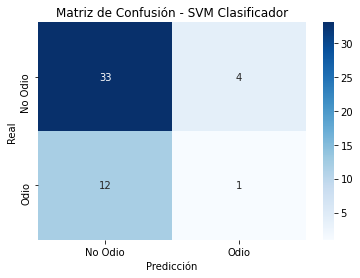

In [4]:
# Entrenar un clasificador SVM usando los embeddings de BERT
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = svm_classifier.predict(X_test)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:", conf_matrix)

# Mostrar el reporte de clasificación para obtener más detalles de rendimiento
print("Reporte de Clasificación:", classification_report(y_test, y_pred))

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Odio', 'Odio'], yticklabels=['No Odio', 'Odio'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - SVM Clasificador')
plt.show()

Como se puede observar, los resultados están lejos de lo deseado. 

Para solucionar esto, pueden intentarse varias opciones:
- Cambiar el clasificador de ML. Se pueden probar otros con RandomForest o kNN. 
- Usar otro modelo de embedding. ¿Y si hay algún modelo de embedding entrenado específicamente para detectar discurso de odio?¿O simplemente de clasificación?

### Ejercicio 1: Implementar alguna mejora

#### Usando un modelo pre-entrenado para generar los embeddings

In [ ]:
from transformers import AutoModelForSequenceClassification
# Cargar el tokenizer y el modelo pre-entrenado BERT
tokenizer = AutoTokenizer.from_pretrained('facebook/roberta-hate-speech-dynabench-r4-target')
bert_model = AutoModelForSequenceClassification.from_pretrained('facebook/roberta-hate-speech-dynabench-r4-target')

In [6]:
# Definir una función para extraer los embeddings utilizando BERT
def extract_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = bert_model(**inputs, output_hidden_states=True)
    # Usar la salida de la última capa oculta como los embeddings
    embeddings = outputs.hidden_states[-2][:, 0, :].numpy()  # Usar solo el token [CLS] para cada secuencia
    return embeddings

# Extraer los embeddings de ejemplo de las primeras 100 muestras (para reducir el tiempo de procesamiento)
X_train = train_data['text']
X_train = extract_embeddings(X_train)
y_train = train_data['label']

X_test = test_data['text']
X_test = extract_embeddings(X_test)
y_test = test_data['label']

Embeddings generados para el dataset de discurso de odio.


In [7]:
bert_model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

[0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 0]
Matriz de Confusión: [[34  3]
 [ 2 11]]
Reporte de Clasificación:               precision    recall  f1-score   support

           0       0.94      0.92      0.93        37
           1       0.79      0.85      0.81        13

    accuracy                           0.90        50
   macro avg       0.87      0.88      0.87        50
weighted avg       0.90      0.90      0.90        50



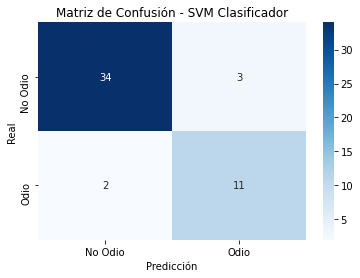

In [9]:
# Entrenar un clasificador SVM usando los embeddings de BERT
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = svm_classifier.predict(X_test)
print(y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:", conf_matrix)

# Mostrar el reporte de clasificación para obtener más detalles de rendimiento
print("Reporte de Clasificación:", classification_report(y_test, y_pred))

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Odio', 'Odio'], yticklabels=['No Odio', 'Odio'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - SVM Clasificador')
plt.show()

#### Usando un modelo pre-entrenado para hacer la inferencia directamente.

In [ ]:
model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
pt_model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
pt_batch = tokenizer(
    test_data['text'],
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt",
)
outputs = pt_model(**pt_batch)
y_pred_test = torch.argmax(outputs.logits, dim=1)
y_gt_test = y_test

Matriz de Confusión: [[36  1]
 [ 3 10]]
Reporte de Clasificación:               precision    recall  f1-score   support

           0       0.92      0.97      0.95        37
           1       0.91      0.77      0.83        13

    accuracy                           0.92        50
   macro avg       0.92      0.87      0.89        50
weighted avg       0.92      0.92      0.92        50



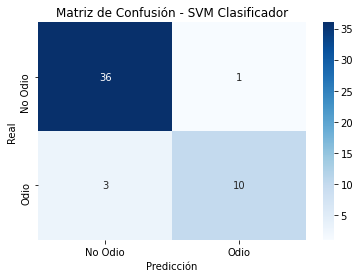

In [20]:
conf_matrix = confusion_matrix(y_gt_test, y_pred_test)
print("Matriz de Confusión:", conf_matrix)

# Mostrar el reporte de clasificación para obtener más detalles de rendimiento
print("Reporte de Clasificación:", classification_report(y_test, y_pred_test))

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Odio', 'Odio'], yticklabels=['No Odio', 'Odio'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - SVM Clasificador')
plt.show()

#### Ejercicio 2

Intenta predecir la clase de varias frases que incorpores en el siguiente array:

[0 0]
Matriz de Confusión: [[1 0]
 [1 0]]
Reporte de Clasificación:               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\Marcos\Programas\Python3.8\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Marcos\Programas\Python3.8\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Marcos\Programas\Python3.8\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


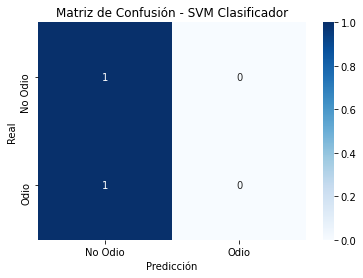

In [19]:
array_inferencia = ["Me ha parecido muy bien el comentario.","¡Eres un inepto!"]
array_gt = [0,1]

array_inferencia_embeddings = extract_embeddings(array_inferencia)


# Predecir en el conjunto de prueba
y_pred_ej2 = svm_classifier.predict(array_inferencia_embeddings)
print(y_pred_ej2)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(array_gt, y_pred_ej2)
print("Matriz de Confusión:", conf_matrix)

# Mostrar el reporte de clasificación para obtener más detalles de rendimiento
print("Reporte de Clasificación:", classification_report(array_gt, y_pred_ej2))

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Odio', 'Odio'], yticklabels=['No Odio', 'Odio'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - SVM Clasificador')
plt.show()

#### Usar un pipeline

In [11]:
test_data_text = test_data["text"]
test_data_label = test_data["label"]

In [16]:
classifier = pipeline(model="facebook/roberta-hate-speech-dynabench-r4-target", batch_size=1)
res_classifier = classifier(test_data_text)
pred_pipeline = [0 if e["label"]== "nothate"  else 1 for e in res_classifier]
print(pred_pipeline)

c:\Users\Marcos\Programas\Python3.8\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Matriz de Confusión: [[36  1]
 [ 3 10]]
Reporte de Clasificación:               precision    recall  f1-score   support

           0       0.92      0.97      0.95        37
           1       0.91      0.77      0.83        13

    accuracy                           0.92        50
   macro avg       0.92      0.87      0.89        50
weighted avg       0.92      0.92      0.92        50



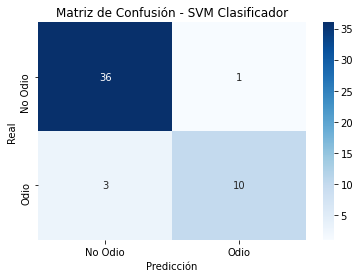

In [17]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(test_data_label, pred_pipeline)
print("Matriz de Confusión:", conf_matrix)

# Mostrar el reporte de clasificación para obtener más detalles de rendimiento
print("Reporte de Clasificación:", classification_report(test_data_label, pred_pipeline))

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Odio', 'Odio'], yticklabels=['No Odio', 'Odio'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - SVM Clasificador')
plt.show()